In [16]:
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

# Set the checkpoint directory.
MODEL_CKPT_DIR = 'model_params_big_test'
# MODEL_CKPT_DIR = 'res_balanced_accuracy'
# MODEL_CKPT_DIR = 'res_f1'

# Paths to the saved model and scaler.
xgb_model_path = Path(MODEL_CKPT_DIR) / 'xgboost_model.json'
scaler_path = Path(MODEL_CKPT_DIR) / 'std_scaler.bin'

# Load the scaler and the pre-trained XGBoost model.
scaler = joblib.load(scaler_path)
model = xgb.XGBClassifier()
model.load_model(xgb_model_path)

In [17]:
DATA_FILE = Path(MODEL_CKPT_DIR) / 'data.csv'

# > AVERAGE FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_all_query_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query_pairs.csv'

# > GOOD FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-20_query-23_nonquery-5539_embedded.csv'
DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_pairs.csv'

df_all = pd.read_csv(DATA_FILE)
# df_all.columns.tolist()

In [18]:
N_SKU = 23

subset_sku = pd.Series(df_all.sku_first.unique()).sample(N_SKU, random_state=42).tolist()
df = df_all[df_all['sku_first'].isin(subset_sku)]

print(f'Total Query SKU: {df.sku_first.nunique()}/{df_all.sku_first.nunique()}')
print(f'Total columns: {len(df.columns)}')
df.columns.tolist()

Total Query SKU: 23/23
Total columns: 35


['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'description_first',
 'name_first',
 'options_first',
 'sku_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'description_second',
 'name_second',
 'options_second',
 'sku_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'image_id_first',
 'image_id_second',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [19]:
# Separate the true labels from the dataset.
if 'label' in df.columns:
    y_true = df['label']

# Define the columns that were not used as features during training.
columns_to_drop = [
    'sku_first', 'sku_second',
    'name_first', 'description_first',
    'name_second', 'description_second',
    'options_first', 'options_second',
    'image_url_first', 'image_url_second',
    'image_id_first', 'image_id_second',
    'label'
]

# Create a DataFrame for scaling by dropping the extra columns.
# The original df remains unchanged.
X = df.drop(columns=columns_to_drop, errors='ignore')

# Ensure the columns match exactly what the scaler was trained on.
# The scaler's attribute 'feature_names_in_' holds the expected column names.
if hasattr(scaler, 'feature_names_in_'):
    expected_features = list(scaler.feature_names_in_)
    X_for_scaler = df[expected_features]
else:
    X_for_scaler = df

# print("Columns used for scaling:", X_for_scaler.columns.tolist())

# Scale the features using the loaded scaler.
X_scaled = scaler.transform(X_for_scaler)
X.columns.tolist()

['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [20]:
[
 # призаначены для первой таблицы
 'balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',

# призаначены для второй таблицы
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',

 # одинаковые для обеих таблиц
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',

# ссылки на изображения
 'url_first',
 'url_second',

# расстояния между эмбеддингами
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim'
]

['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [21]:
import pandas as pd

# Compute predictions and probabilities (using your pre-trained model)
predictions = model.predict(X_scaled)
predicted_probas = model.predict_proba(X_scaled)

# For binary classification, use the positive class probability;
# for multiclass, use the highest probability of any class.
if predicted_probas.shape[1] == 2:
    sort_probas = predicted_probas[:, 1]
else:
    sort_probas = predicted_probas.max(axis=1)

# Create a DataFrame with the predictions and probabilities.
# We align by the original dataframe's index.
results_df = pd.DataFrame({
    'prediction': predictions,
    'proba': sort_probas
}, index=df.index)

# Concatenate the predictions to the original DataFrame.
df_with_preds = pd.concat([df, results_df], axis=1)

# Instead of using groupby.apply (with include_groups), sort directly:
df_grouped_sorted = df_with_preds.sort_values(
    by=['sku_first', 'proba'], ascending=[True, False]
)

print("Data grouped by sku_first and sorted within each group by probability:")
df_grouped_sorted.columns.tolist()

matches_df = df_grouped_sorted.copy()
matches_df['price_delta_abs'] = matches_df['final_price_first'] - matches_df['final_price_second']
matches_df['price_delta_rel'] = (
    (matches_df['final_price_first'] - matches_df['final_price_second'])
    / matches_df['final_price_first']
).abs()

matches_df = matches_df[matches_df.prediction == 1]

matches_df_short = matches_df[[
    'sku_first', 'sku_second', 'prediction', 'proba',
    'url_first', 'url_second'
]]
matches_df_short.head()

Data grouped by sku_first and sorted within each group by probability:


,sku_first,sku_second,prediction,proba,url_first,url_second
300,491268805,1573965314,1,0.915313,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/1573965314/
305,491268805,1674617748,1,0.847642,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/1674617748/
301,491268805,1574052518,1,0.839449,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/1574052518/
320,491268805,484538633,1,0.819736,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/484538633/
319,491268805,601310061,1,0.819248,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/601310061/


In [22]:
from pathlib import Path
import pandas as pd

DATA_PATH = 'data'

file_path = (
    Path(DATA_PATH) /
    Path('tables_OZ_geo_5500') /
    'Ozon_Crawler_Latest_info2025-04-07-12-57-51.xlsx'
)

descr_source_df = pd.read_excel(file_path)
descr_source_df.columns.tolist()

['Sku (Sku)',
 'Фото (CoverImage)',
 'Название товара (ProductName)',
 'Продавец (SellerName)',
 'Бренд (BrandName)',
 'Название категории (CategoryName)',
 'Цена соинвест (DiscountPrice)',
 'Цена по карте (OzonCardPrice)',
 'Сток FBO (StockFbm)',
 'Сток FBS (StockFbs)',
 'Ошибка загрузки (CrawlerError)',
 'Валюта (Currency)',
 'Цена до скидки (BasePrice)',
 'Рейтинг товара (AvgRating)',
 'Количество отзывов (Reviews)',
 'Описание (Description)',
 'Rich-контент (RichContent)',
 'Ссылка на карточку',
 'SellerProductId (SellerProductId)']

In [23]:
matches_df[['balance_first', 'balance_second']].describe()

,balance_first,balance_second
count,981.000000,981.000000
mean,212.921509,255.340469
std,260.438803,416.634345
min,0.000000,0.000000
25%,41.000000,6.000000
50%,110.000000,50.000000
75%,255.000000,188.000000
max,899.000000,2056.000000


In [43]:
TOP_K = 5
DISPLAY_STATS = False
DISPLAY_NAME = True

for query_idx, (query_sku, query_df) in enumerate(matches_df.groupby('sku_first')):
    print(f'Query #{query_idx} '+'#' * 40)
    print(f"Query SKU: {query_sku}")
    print(f'Query URL: {query_df['url_first'].iloc[0]}')

    if DISPLAY_STATS:
        display(query_df[[
            'balance_first',
            'comments_first',
            'rating_first',
        ]].iloc[0].to_frame().T)
    if DISPLAY_NAME:
        print(f"Query Name: {query_df['name_first'].iloc[0]}")
        # print(f"Query Description: {query_df['description_first'].iloc[0]}")

    print('-' * 60)
    for top_k_idx, row in query_df.reset_index(drop=True).iterrows():
        if top_k_idx == TOP_K-1:
            break
        print(f"Top-{top_k_idx} SKU: {row['sku_second']}")
        print(f'Top-{top_k_idx} URL: {row['url_second']}')

        if DISPLAY_STATS:
            display(row[['balance_second',
                        'comments_second',
                        'rating_second',
                        ]].to_frame().T)

        if DISPLAY_NAME:
            print(f'Top-{top_k_idx} Name: {row['name_second']}')
            # print(f'Top-{top_k_idx} Description: {row['description_second']}')

        print()
        
    print()

# TODO: исключить карты, которые не в наличии?

Query #0 ########################################
Query SKU: 491268805
Query URL: https://www.ozon.ru/context/detail/id/491268805/
Query Name: Карта Москвы настенная,100х70 см "Москва современная с линиями метро"
------------------------------------------------------------
Top-0 SKU: 1573965314
Top-0 URL: https://www.ozon.ru/context/detail/id/1573965314/
Top-0 Name: Настенная карта Москвы "Москва современная с линиями метро"/размер 102х143

Top-1 SKU: 1674617748
Top-1 URL: https://www.ozon.ru/context/detail/id/1674617748/
Top-1 Name: Настенная карта Москвы с каждым домом в тубусе, 157х210 см, матовая ламинация, "АГТ Геоцентр"

Top-2 SKU: 1574052518
Top-2 URL: https://www.ozon.ru/context/detail/id/1574052518/
Top-2 Name: Настенная карта Москвы на отвесах"Москва современная с линиями метро"/размер 102х143

Top-3 SKU: 484538633
Top-3 URL: https://www.ozon.ru/context/detail/id/484538633/
Top-3 Name: Настенная автомобильная карта Москвы в тубусе, 107х160 см, матовая ламинация, для офиса, шк

In [26]:
def construct_wide_table(df, top_k):
    """
    Constructs a wide table such that each row corresponds to a unique query SKU and contains:
    
      Query_SKU, Top-1_SKU, Top-2_SKU, ... Top-k_SKU,
      Query_URL, Top-1_URL, Top-2_URL, ... Top-k_URL,
      Top-1_Proba, Top-2_Proba, ... Top-k_Proba
      
    Only candidates with a positive prediction (prediction == 1) are included.
    If there are fewer than top_k positive predictions for a query, the remaining columns are filled with None.
    """
    wide_rows = []
    # Process each unique query SKU.
    for query_sku, group in df.groupby('sku_first'):
        # Consider only candidates with positive prediction.
        group_positive = group[group['prediction'] == 1]
        # Sort the positive candidates by probability in descending order.
        group_sorted = group_positive.sort_values(by='proba', ascending=False).reset_index(drop=True)
        # Assume the query URL is the same for every row with the same query SKU.
        query_url = group_sorted.loc[0, 'url_first'] if not group_sorted.empty else None
        
        # Build the row dictionary with the desired column order.
        row = {}
        row['Query_SKU'] = query_sku
        
        # Add candidate SKU columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_SKU'] = group_sorted.loc[i, 'sku_second']
            else:
                row[f'Top-{i+1}_SKU'] = None
        
        # Add the Query URL.
        row['Query_URL'] = query_url
        
        # Add candidate URL columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_URL'] = group_sorted.loc[i, 'url_second']
            else:
                row[f'Top-{i+1}_URL'] = None
        
        # Add candidate probability columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_proba'] = group_sorted.loc[i, 'proba']
            else:
                row[f'Top-{i+1}_proba'] = None
        
        wide_rows.append(row)
    return pd.DataFrame(wide_rows)


In [27]:
# --- Set your desired top_k (e.g. 5) and construct the wide table.
TOP_K = 5

matches_wide_df = construct_wide_table(df_grouped_sorted, TOP_K)
matches_wide_df = matches_wide_df.dropna()
matches_wide_df

,Query_SKU,Top-1_SKU,Top-2_SKU,Top-3_SKU,Top-4_SKU,Top-5_SKU,Query_URL,Top-1_URL,Top-2_URL,Top-3_URL,Top-4_URL,Top-5_URL,Top-1_proba,Top-2_proba,Top-3_proba,Top-4_proba,Top-5_proba
0,491268805,1.573965e+09,1.674618e+09,1.574053e+09,4.845386e+08,6.013101e+08,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/1573965314/,https://www.ozon.ru/context/detail/id/1674617748/,https://www.ozon.ru/context/detail/id/1574052518/,https://www.ozon.ru/context/detail/id/484538633/,https://www.ozon.ru/context/detail/id/601310061/,0.915313,0.847642,0.839449,0.819736,0.819248
1,491270272,1.247589e+09,3.394855e+08,1.005612e+09,1.581230e+09,1.876314e+09,https://www.ozon.ru/context/detail/id/491270272/,https://www.ozon.ru/context/detail/id/1247589234/,https://www.ozon.ru/context/detail/id/339485530/,https://www.ozon.ru/context/detail/id/1005611591/,https://www.ozon.ru/context/detail/id/1581230356/,https://www.ozon.ru/context/detail/id/1876314221/,0.909153,0.896915,0.891650,0.867214,0.865902
2,491270369,1.604850e+09,1.283826e+09,1.787263e+08,1.787348e+08,1.857130e+09,https://www.ozon.ru/context/detail/id/491270369/,https://www.ozon.ru/context/detail/id/1604850472/,https://www.ozon.ru/context/detail/id/1283826235/,https://www.ozon.ru/context/detail/id/178726257/,https://www.ozon.ru/context/detail/id/178734811/,https://www.ozon.ru/context/detail/id/1857130100/,0.954441,0.941846,0.930370,0.920919,0.920136
3,491271284,8.085601e+08,1.887527e+09,1.934870e+09,2.449357e+08,1.581230e+09,https://www.ozon.ru/context/detail/id/491271284/,https://www.ozon.ru/context/detail/id/808560063/,https://www.ozon.ru/context/detail/id/1887527156/,https://www.ozon.ru/context/detail/id/1934870477/,https://www.ozon.ru/context/detail/id/244935723/,https://www.ozon.ru/context/detail/id/1581230356/,0.936157,0.927800,0.917852,0.916111,0.915952
4,491271320,1.436512e+09,1.857130e+09,1.314313e+09,8.516236e+08,8.548184e+08,https://www.ozon.ru/context/detail/id/491271320/,https://www.ozon.ru/context/detail/id/1436512495/,https://www.ozon.ru/context/detail/id/1857130100/,https://www.ozon.ru/context/detail/id/1314312894/,https://www.ozon.ru/context/detail/id/851623566/,https://www.ozon.ru/context/detail/id/854818377/,0.939359,0.937245,0.935107,0.931962,0.925865
5,491271339,1.674618e+09,1.641860e+09,5.367145e+08,4.845777e+08,4.845386e+08,https://www.ozon.ru/context/detail/id/491271339/,https://www.ozon.ru/context/detail/id/1674617748/,https://www.ozon.ru/context/detail/id/1641860393/,https://www.ozon.ru/context/detail/id/536714481/,https://www.ozon.ru/context/detail/id/484577673/,https://www.ozon.ru/context/detail/id/484538633/,0.707331,0.707129,0.691477,0.687745,0.683874
6,491271768,5.367123e+08,5.367145e+08,6.793703e+08,1.674618e+09,5.367123e+08,https://www.ozon.ru/context/detail/id/491271768/,https://www.ozon.ru/context/detail/id/536712251/,https://www.ozon.ru/context/detail/id/536714481/,https://www.ozon.ru/context/detail/id/679370286/,https://www.ozon.ru/context/detail/id/1674617748/,https://www.ozon.ru/context/detail/id/536712270/,0.747939,0.742852,0.740689,0.732629,0.725933
7,491273438,1.787338e+08,1.586715e+09,1.787348e+08,1.787263e+08,1.436529e+09,https://www.ozon.ru/context/detail/id/491273438/,https://www.ozon.ru/context/detail/id/178733797/,https://www.ozon.ru/context/detail/id/1586714576/,https://www.ozon.ru/context/detail/id/178734811/,https://www.ozon.ru/context/detail/id/178726257/,https://www.ozon.ru/context/detail/id/1436528883/,0.868717,0.868211,0.863334,0.853766,0.840696
8,491273791,6.255392e+08,1.436529e+09,1.919437e+09,1.283826e+09,1.438364e+09,https://www.ozon.ru/context/detail/id/491273791/,https://www.ozon.ru/context/detail/id/625539152/,https://www.ozon.ru/context/detail/id/1436528883/,https://www.ozon.ru/context/detail/id/1919437475/,https://www.ozon.ru/context/detail/id/1283826235/,https://www.ozon.ru/context/detail/id/1438364306/,0.934597,0.924003,0.922723,0.920989,0.917678
9,491279127,1.436685e+09,9.742860e+08,1.436514e+09

In [36]:
subset_cols = [
    'Query_SKU',
    # 'Top-1_SKU', 'Top-2_SKU', 'Top-3_SKU', 'Top-4_SKU', 'Top-5_SKU',
    # 'Query_URL',
    # 'Top-1_URL', 'Top-2_URL', 'Top-3_URL', 'Top-4_URL', 'Top-5_URL',
    # 'Top-1_proba', 'Top-2_proba', 'Top-3_proba', 'Top-4_proba', 'Top-5_proba'
]

output_file_path = (
    Path(DATA_FILE).parent /
    Path('test_results') / 
    'result-errors-template.csv'
    # (f'result-errors-template-{MODEL_CKPT_DIR}_' + Path(DATA_FILE).name)
)
matches_wide_df.to_clipboard(index=False, header=True, excel=True, columns=subset_cols)
matches_wide_df.to_csv(output_file_path, index=False, header=True, columns=subset_cols)

In [ ]:
DATA_PATH = 'data'

output_file_path = (
    Path(DATA_FILE).parent /
    Path('test_results') / 
    (f'result-{MODEL_CKPT_DIR}_' + Path(DATA_FILE).name)
)
output_file_path.parent.mkdir(parents=True, exist_ok=True)
# output_file_path

matches_wide_df.to_csv(output_file_path, index=None)

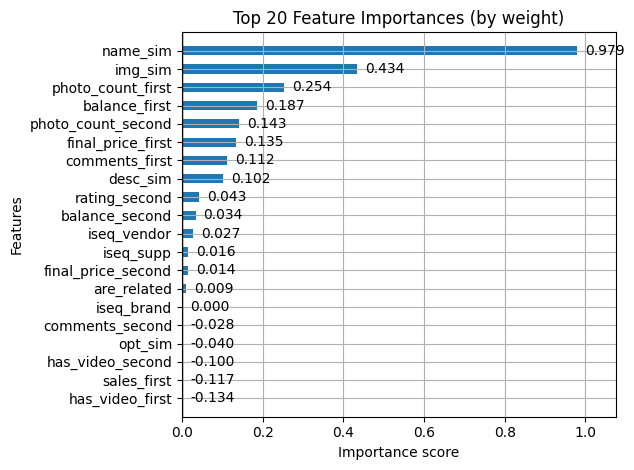

In [315]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assume you already have a scaler and a DataFrame X_for_scaler that were used during training.
# For example, earlier you may have extracted:
# if hasattr(scaler, 'feature_names_in_'):
#     feature_names = list(scaler.feature_names_in_)
# else:
#     feature_names = X_for_scaler.columns.tolist()

if hasattr(scaler, 'feature_names_in_'):
    feature_names = list(scaler.feature_names_in_)
else:
    feature_names = X_for_scaler.columns.tolist()

# Set the original feature names in the booster
booster = model.get_booster()
booster.feature_names = feature_names

# Now plot the feature importance using the booster (which now has the correct names)
ax = xgb.plot_importance(
    booster,
    importance_type='weight',
    max_num_features=20,
    height=0.5,
    show_values=False  # Turn off default text; we'll annotate manually.
)

plt.title("Top 20 Feature Importances (by weight)")
# Optional: Draw a vertical line at x=0 for clarity when some weights are negative.
plt.axvline(x=0, color='black', linewidth=1)

# Label each bar manually so they're formatted nicely.
offset = 0.02  # This offset shifts the label a little to the right.
for patch in ax.patches:
    bar_width = patch.get_width()
    bar_y_center = patch.get_y() + patch.get_height() / 2
    # For positive values, label at the bar's end; for negative, anchor at x=0.
    label_x = bar_width + offset if bar_width >= 0 else 0 + offset
    ax.text(label_x, bar_y_center, f"{bar_width:.3f}", ha='left', va='center')

plt.tight_layout()
plt.show()
